In [1]:
# ⚙️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS BACKTEST
# =============================================================================
# Modifica questi parametri per ottimizzare la strategia
# =============================================================================

print("🎛️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS")
print("=" * 60)

# 📊 PARAMETRI BOLLINGER BANDS
BB_PERIOD = 400             # Periodo per media mobile (tipicamente 20)
BB_STD_DEV = 1.0           # Deviazioni standard (tipicamente 2.0)

# 📈 PARAMETRI STRATEGIA  
ENABLE_LONG = True         # Abilita posizioni LONG
ENABLE_SHORT = True        # Abilita posizioni SHORT

# 🎯 PARAMETRI ESECUZIONE
MIN_SPREAD_PIPS = 0.0      # Spread minimo per eseguire trade (0 = nessun filtro)
MAX_SPREAD_PIPS = 5.0      # Spread massimo per eseguire trade (5 pips)
STOP_LOSS_PIPS = 100       # Stop loss in pips per ogni trade

# 📊 STAMPA CONFIGURAZIONE
print(f"📊 Bollinger Bands:")
print(f"   • Periodo: {BB_PERIOD}")
print(f"   • Deviazioni Standard: {BB_STD_DEV}")
print(f"📈 Strategia:")
print(f"   • Long abilitati: {'✅' if ENABLE_LONG else '❌'}")
print(f"   • Short abilitati: {'✅' if ENABLE_SHORT else '❌'}")
print(f"🎯 Filtri Esecuzione:")
print(f"   • Spread minimo: {MIN_SPREAD_PIPS} pips")
print(f"   • Spread massimo: {MAX_SPREAD_PIPS} pips")
print(f"   • Stop Loss: {STOP_LOSS_PIPS} pips")
print("=" * 60)
print("✅ Parametri configurati! Procedi con l'esecuzione del backtest.")
print("💡 TIP: Modifica i valori sopra e ri-esegui tutte le celle per testare nuovi parametri.")

🎛️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS
📊 Bollinger Bands:
   • Periodo: 400
   • Deviazioni Standard: 1.0
📈 Strategia:
   • Long abilitati: ✅
   • Short abilitati: ✅
🎯 Filtri Esecuzione:
   • Spread minimo: 0.0 pips
   • Spread massimo: 5.0 pips
   • Stop Loss: 100 pips
✅ Parametri configurati! Procedi con l'esecuzione del backtest.
💡 TIP: Modifica i valori sopra e ri-esegui tutte le celle per testare nuovi parametri.


In [2]:
import pandas as pd

data = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1monthTick.csv'
df = pd.read_csv(data)

In [3]:
# Esploriamo la struttura del dataframe
print("Informazioni generali sul dataset:")
print(f"Forma del dataset: {df.shape}")
print(f"Periodo dati: dal {df['timestamp'].min()} al {df['timestamp'].max()}")
print("\nTipi di dati:")
print(df.dtypes)
print("\nPrime 10 righe:")
print(df.head(10))

Informazioni generali sul dataset:
Forma del dataset: (5572578, 5)
Periodo dati: dal 2025-01-01 22:04:01 al 2025-04-01 23:59:49

Tipi di dati:
timestamp     object
askPrice     float64
bidPrice     float64
askVolume    float64
bidVolume    float64
dtype: object

Prime 10 righe:
             timestamp  askPrice  bidPrice  askVolume  bidVolume
0  2025-01-01 22:04:01   0.82821   0.82563       1.50       0.45
1  2025-01-01 22:04:02   0.82821   0.82562       1.50       0.45
2  2025-01-01 22:04:33   0.82809   0.82567       0.45       0.45
3  2025-01-01 22:04:34   0.82802   0.82620       0.45       0.45
4  2025-01-01 22:04:35   0.82795   0.82619       0.45       0.45
5  2025-01-01 22:04:37   0.82794   0.82619       0.45       0.45
6  2025-01-01 22:04:38   0.82795   0.82619       0.45       0.45
7  2025-01-01 22:04:48   0.82793   0.82620       0.45       0.45
8  2025-01-01 22:04:49   0.82795   0.82619       0.45       0.45
9  2025-01-01 22:05:04   0.82835   0.82522       0.90       0.90
Period

In [4]:
import pandas as pd
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Ricarico i dati dopo restart del kernel
data = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1monthTick.csv'
df = pd.read_csv(data)
print(f"Dati ricaricati: {df.shape[0]} tick da {df['timestamp'].min()} a {df['timestamp'].max()}")

Dati ricaricati: 5572578 tick da 2025-01-01 22:04:01 a 2025-04-01 23:59:49


In [5]:
# Preparazione dati tick per resampling realistico
print("🔄 Preparazione dati tick...")

# Conversione timestamp e ordinamento
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Calcolo mid price per le candele
df['mid_price'] = (df['askPrice'] + df['bidPrice']) / 2

# Set timestamp come index per resampling
df_indexed = df.set_index('timestamp')

print(f"✅ Dati preparati: {len(df_indexed)} tick ordinati cronologicamente")
print(f"Periodo: {df_indexed.index.min()} → {df_indexed.index.max()}")
print(f"Spread medio: {(df_indexed['askPrice'] - df_indexed['bidPrice']).mean()*10000:.1f} pips")
print(f"Spread min/max: {(df_indexed['askPrice'] - df_indexed['bidPrice']).min()*10000:.1f}/{(df_indexed['askPrice'] - df_indexed['bidPrice']).max()*10000:.1f} pips")

🔄 Preparazione dati tick...
✅ Dati preparati: 5572578 tick ordinati cronologicamente
Periodo: 2025-01-01 22:04:01 → 2025-04-01 23:59:49
Spread medio: 0.9 pips
Spread min/max: 0.1/32.9 pips
✅ Dati preparati: 5572578 tick ordinati cronologicamente
Periodo: 2025-01-01 22:04:01 → 2025-04-01 23:59:49
Spread medio: 0.9 pips
Spread min/max: 0.1/32.9 pips


In [6]:
# Resampling a candele 1min mantenendo bid/ask
print("🕐 Resampling tick → candele 1min...")

# Resampling mantenendo OHLC per mid_price + ultimo bid/ask
ohlc_data = df_indexed['mid_price'].resample('1T').agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min',
    'close': 'last'
}).dropna()

# Per ogni candela, prendo l'ultimo bid/ask disponibile (più realistico)
bid_ask_data = df_indexed[['askPrice', 'bidPrice']].resample('1T').agg({
    'askPrice': 'last',  # Ultimo ask del minuto
    'bidPrice': 'last'   # Ultimo bid del minuto  
}).dropna()

# Combino i dati
candles = pd.concat([ohlc_data, bid_ask_data], axis=1).dropna()

print(f"✅ {len(candles)} candele 1min create")
print(f"Periodo candele: {candles.index[0]} → {candles.index[-1]}")
print(f"Dati candele completi: OHLC + bid/ask finale per ogni minuto")

# Visualizzo alcune candele
print("\n📊 Prime 5 candele:")
print(candles.head())

🕐 Resampling tick → candele 1min...
✅ 91984 candele 1min create
Periodo candele: 2025-01-01 22:04:00 → 2025-04-01 23:59:00
Dati candele completi: OHLC + bid/ask finale per ogni minuto

📊 Prime 5 candele:
                         open      high       low     close  askPrice  \
timestamp                                                               
2025-01-01 22:04:00  0.826920  0.827110  0.826880  0.827070   0.82795   
2025-01-01 22:05:00  0.826785  0.827325  0.826635  0.827325   0.82790   
2025-01-01 22:06:00  0.827320  0.827380  0.827255  0.827340   0.82795   
2025-01-01 22:07:00  0.827320  0.827325  0.827245  0.827245   0.82784   
2025-01-01 22:08:00  0.827245  0.827290  0.827240  0.827285   0.82783   

                     bidPrice  
timestamp                      
2025-01-01 22:04:00   0.82619  
2025-01-01 22:05:00   0.82675  
2025-01-01 22:06:00   0.82673  
2025-01-01 22:07:00   0.82665  
2025-01-01 22:08:00   0.82674  
✅ 91984 candele 1min create
Periodo candele: 2025-01-01 22:0

In [7]:
# Calcolo Bollinger Bands ottimizzato
print("📈 Calcolo Bollinger Bands...")

def calculate_bollinger_bands(prices, window=20, std_dev=2):
    """Calcolo vettorizzato delle Bollinger Bands"""
    # Rolling mean
    middle_band = prices.rolling(window=window).mean()
    
    # Rolling standard deviation  
    rolling_std = prices.rolling(window=window).std()
    
    # Bande superiore e inferiore
    upper_band = middle_band + (rolling_std * std_dev)
    lower_band = middle_band - (rolling_std * std_dev)
    
    return middle_band, upper_band, lower_band

# Calcolo Bollinger Bands sui close usando parametri configurabili
middle_band, upper_band, lower_band = calculate_bollinger_bands(
    candles['close'], 
    window=BB_PERIOD, 
    std_dev=BB_STD_DEV
)

# Aggiungo alle candele
candles['bb_middle'] = middle_band
candles['bb_upper'] = upper_band  
candles['bb_lower'] = lower_band

# Rimuovo righe con NaN (primi 20 valori)
candles = candles.dropna()

print(f"✅ Bollinger Bands calcolate per {len(candles)} candele")
print(f"Periodo backtest: {candles.index[0]} → {candles.index[-1]}")
print(f"Campioni validi per trading: {len(candles)}")

# Mostro esempio delle bande
print("\n📊 Esempio candele con Bollinger Bands:")
print(candles[['close', 'bb_lower', 'bb_middle', 'bb_upper', 'askPrice', 'bidPrice']].head())

📈 Calcolo Bollinger Bands...
✅ Bollinger Bands calcolate per 91585 candele
Periodo backtest: 2025-01-02 04:43:00 → 2025-04-01 23:59:00
Campioni validi per trading: 91585

📊 Esempio candele con Bollinger Bands:
                        close  bb_lower  bb_middle  bb_upper  askPrice  \
timestamp                                                                
2025-01-02 04:43:00  0.827205  0.827089   0.827297  0.827506   0.82725   
2025-01-02 04:44:00  0.827220  0.827089   0.827298  0.827506   0.82726   
2025-01-02 04:45:00  0.827245  0.827089   0.827297  0.827506   0.82728   
2025-01-02 04:46:00  0.827275  0.827089   0.827297  0.827505   0.82731   
2025-01-02 04:47:00  0.827365  0.827089   0.827298  0.827506   0.82741   

                     bidPrice  
timestamp                      
2025-01-02 04:43:00   0.82716  
2025-01-02 04:44:00   0.82718  
2025-01-02 04:45:00   0.82721  
2025-01-02 04:46:00   0.82724  
2025-01-02 04:47:00   0.82732  


In [8]:
# Backtest Engine Ottimizzato con Numba
print("⚡ Preparazione backtest engine ottimizzato...")

@jit(nopython=True)
def bollinger_backtest_engine(closes, bb_upper, bb_lower, bb_middle, ask_prices, bid_prices, 
                             enable_long=True, enable_short=True, min_spread=0.0, max_spread=5.0, stop_loss_pips=100):
    """
    Backtest engine ultra-ottimizzato con Numba + STOP LOSS
    Strategia: 
    - LONG quando close < lower_band (buy ask, exit bid at middle OR stop loss)
    - SHORT quando close > upper_band (sell bid, exit ask at middle OR stop loss)
    
    Parametri configurabili:
    - enable_long/enable_short: abilita/disabilita direzioni
    - min_spread/max_spread: filtri per spread in pips
    - stop_loss_pips: stop loss in pips (esecuzione realistica bid/ask)
    """
    n = len(closes)
    
    # Arrays per risultati
    positions = np.zeros(n)  # 0=flat, 1=long, -1=short
    entry_prices = np.zeros(n)
    exit_prices = np.zeros(n)
    pnl_pips = np.zeros(n)
    equity_curve = np.zeros(n)
    exit_reasons = np.zeros(n)  # 0=no exit, 1=target, 2=stop loss
    
    # Stato trading
    current_position = 0
    entry_price = 0.0
    equity = 0.0
    stop_loss_price = 0.0
    
    for i in range(1, n):  # Start from 1 to avoid look-ahead bias
        close_price = closes[i-1]  # Uso close della candela precedente (evito look-ahead)
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        current_middle = bb_middle[i]
        
        # Calcolo spread corrente in pips
        current_spread = (current_ask - current_bid) * 10000
        
        # Controllo exit se in posizione
        if current_position != 0:
            exit_condition = False
            exit_reason = 0
            
            if current_position == 1:  # Long position
                # CONTROLLO STOP LOSS PRIMA (priorità)
                # Per long: stop loss quando il BID scende sotto stop_loss_price
                if current_bid <= stop_loss_price:
                    exit_price = current_bid  # Vendo al bid (realistico)
                    pnl = (exit_price - entry_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 2  # Stop loss
                    
                # CONTROLLO TARGET (middle band)
                elif close_price >= current_middle:
                    exit_price = current_bid  # Vendo al bid
                    pnl = (exit_price - entry_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 1  # Target
                    
            elif current_position == -1:  # Short position  
                # CONTROLLO STOP LOSS PRIMA (priorità)
                # Per short: stop loss quando l'ASK sale sopra stop_loss_price
                if current_ask >= stop_loss_price:
                    exit_price = current_ask  # Compro all'ask (realistico)
                    pnl = (entry_price - exit_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 2  # Stop loss
                    
                # CONTROLLO TARGET (middle band)
                elif close_price <= current_middle:
                    exit_price = current_ask  # Compro all'ask
                    pnl = (entry_price - exit_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 1  # Target
            
            if exit_condition:
                pnl_pips[i] = pnl
                exit_prices[i] = exit_price
                exit_reasons[i] = exit_reason
                equity += pnl
                current_position = 0
                entry_price = 0.0
                stop_loss_price = 0.0
        
        # Controllo entry se non in posizione e spread accettabile
        if current_position == 0 and min_spread <= current_spread <= max_spread:
            # Segnale LONG: close sotto lower band (se abilitato)
            if enable_long and close_price < bb_lower[i-1]:  # Uso banda precedente
                current_position = 1
                entry_price = current_ask  # Compro all'ask
                entry_prices[i] = entry_price
                # STOP LOSS per LONG: entry_price - stop_loss (in decimali)
                stop_loss_price = entry_price - (stop_loss_pips / 10000)
                
            # Segnale SHORT: close sopra upper band (se abilitato)    
            elif enable_short and close_price > bb_upper[i-1]:  # Uso banda precedente
                current_position = -1
                entry_price = current_bid  # Vendo al bid
                entry_prices[i] = entry_price
                # STOP LOSS per SHORT: entry_price + stop_loss (in decimali)
                stop_loss_price = entry_price + (stop_loss_pips / 10000)
        
        positions[i] = current_position
        equity_curve[i] = equity
    
    return positions, entry_prices, exit_prices, pnl_pips, equity_curve, exit_reasons

# Preparazione dati per Numba (solo numpy arrays)
closes = candles['close'].values
bb_upper = candles['bb_upper'].values
bb_lower = candles['bb_lower'].values  
bb_middle = candles['bb_middle'].values
ask_prices = candles['askPrice'].values
bid_prices = candles['bidPrice'].values

print(f"✅ Dati preparati per backtest: {len(closes)} candele")
print("🚀 Avvio backtest realistico (bid/ask execution)...")

⚡ Preparazione backtest engine ottimizzato...
✅ Dati preparati per backtest: 91585 candele
🚀 Avvio backtest realistico (bid/ask execution)...


In [9]:
# Esecuzione backtest
import time
start_time = time.time()

positions, entry_prices, exit_prices, pnl_pips, equity_curve, exit_reasons = bollinger_backtest_engine(
    closes, bb_upper, bb_lower, bb_middle, ask_prices, bid_prices,
    enable_long=ENABLE_LONG, 
    enable_short=ENABLE_SHORT, 
    min_spread=MIN_SPREAD_PIPS, 
    max_spread=MAX_SPREAD_PIPS,
    stop_loss_pips=STOP_LOSS_PIPS
)

execution_time = time.time() - start_time

# Aggiungo risultati al DataFrame
candles['position'] = positions
candles['entry_price'] = entry_prices  
candles['exit_price'] = exit_prices
candles['pnl_pips'] = pnl_pips
candles['equity_curve'] = equity_curve
candles['exit_reason'] = exit_reasons  # 0=no exit, 1=target, 2=stop loss

print(f"✅ Backtest completato in {execution_time:.2f} secondi")
print(f"⚡ Performance: {len(candles)/execution_time:.0f} candele/secondo")

# Statistiche trading
trades = candles[candles['pnl_pips'] != 0]
total_trades = len(trades)
winning_trades = len(trades[trades['pnl_pips'] > 0])
losing_trades = len(trades[trades['pnl_pips'] < 0])

if total_trades > 0:
    win_rate = (winning_trades / total_trades) * 100
    avg_win = trades[trades['pnl_pips'] > 0]['pnl_pips'].mean() if winning_trades > 0 else 0
    avg_loss = trades[trades['pnl_pips'] < 0]['pnl_pips'].mean() if losing_trades > 0 else 0
    total_pnl = trades['pnl_pips'].sum()
    
    # Analisi motivi di uscita
    target_exits = len(trades[trades['exit_reason'] == 1])  # Target (middle band)
    stop_loss_exits = len(trades[trades['exit_reason'] == 2])  # Stop loss
    
    print(f"\n📊 RISULTATI BACKTEST REALISTICO + STOP LOSS:")
    print(f"Parametri BB: Periodo={BB_PERIOD}, StdDev={BB_STD_DEV}")
    print(f"Filtri: Long={'✅' if ENABLE_LONG else '❌'}, Short={'✅' if ENABLE_SHORT else '❌'}, Spread={MIN_SPREAD_PIPS}-{MAX_SPREAD_PIPS} pips")
    print(f"Stop Loss: {STOP_LOSS_PIPS} pips (esecuzione realistica bid/ask)")
    print(f"Periodo: {candles.index[0].strftime('%Y-%m-%d')} → {candles.index[-1].strftime('%Y-%m-%d')}")
    print(f"Durata: {(candles.index[-1] - candles.index[0]).days} giorni")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}% ({winning_trades}W / {losing_trades}L)")
    print(f"Total P&L: {total_pnl:.1f} pips")
    print(f"Avg Win: {avg_win:.1f} pips")
    print(f"Avg Loss: {avg_loss:.1f} pips")
    print(f"\n🎯 MOTIVI DI USCITA:")
    print(f"Exit al Target (middle band): {target_exits} ({target_exits/total_trades*100:.1f}%)")
    print(f"Exit per Stop Loss: {stop_loss_exits} ({stop_loss_exits/total_trades*100:.1f}%)")
    if avg_loss != 0:
        print(f"Profit Factor: {abs(avg_win * winning_trades / (avg_loss * losing_trades)):.2f}")
else:
    print("❌ Nessun trade eseguito")

✅ Backtest completato in 0.59 secondi
⚡ Performance: 156474 candele/secondo

📊 RISULTATI BACKTEST REALISTICO + STOP LOSS:
Parametri BB: Periodo=400, StdDev=1.0
Filtri: Long=✅, Short=✅, Spread=0.0-5.0 pips
Stop Loss: 100 pips (esecuzione realistica bid/ask)
Periodo: 2025-01-02 → 2025-04-01
Durata: 89 giorni
Total Trades: 665
Win Rate: 70.1% (466W / 199L)
Total P&L: 60.8 pips
Avg Win: 2.5 pips
Avg Loss: -5.6 pips

🎯 MOTIVI DI USCITA:
Exit al Target (middle band): 665 (100.0%)
Exit per Stop Loss: 0 (0.0%)
Profit Factor: 1.05


In [10]:
# 🔍 VERIFICA DETTAGLIATA STOP LOSS
print("🔍 VERIFICA FUNZIONAMENTO STOP LOSS")
print("=" * 60)

# Analisi dettagliata dei trade
if total_trades > 0:
    # Statistiche per motivo di uscita
    target_exits = trades[trades['exit_reason'] == 1]
    stop_loss_exits = trades[trades['exit_reason'] == 2]
    
    print(f"📊 ANALISI MOTIVI DI USCITA:")
    print(f"Total Trade: {total_trades}")
    print(f"Exit per Target: {len(target_exits)} ({len(target_exits)/total_trades*100:.1f}%)")
    print(f"Exit per Stop Loss: {len(stop_loss_exits)} ({len(stop_loss_exits)/total_trades*100:.1f}%)")
    
    if len(stop_loss_exits) > 0:
        print(f"\n🛑 ANALISI STOP LOSS:")
        print(f"P&L medio Stop Loss: {stop_loss_exits['pnl_pips'].mean():.1f} pips")
        print(f"P&L range Stop Loss: {stop_loss_exits['pnl_pips'].min():.1f} to {stop_loss_exits['pnl_pips'].max():.1f} pips")
        
        print(f"\n📋 PRIMI 5 STOP LOSS:")
        for idx, trade in stop_loss_exits.head().iterrows():
            direction = "LONG" if trade['position'] == 1 else "SHORT"
            print(f"  {direction} @ {idx.strftime('%Y-%m-%d %H:%M')} | Entry: {trade['entry_price']:.5f} | Exit: {trade['exit_price']:.5f} | P&L: {trade['pnl_pips']:.1f} pips")
    else:
        print(f"\n✅ NESSUN STOP LOSS ATTIVATO")
        print(f"Questo può significare:")
        print(f"  • Le bande BB sono molto larghe (BB_PERIOD={BB_PERIOD}, STD_DEV={BB_STD_DEV})")
        print(f"  • La volatilità del mercato è bassa")
        print(f"  • Lo stop loss di {STOP_LOSS_PIPS} pips è troppo largo")
        
    # Controllo se ci sono trade con grosse perdite
    big_losses = trades[trades['pnl_pips'] < -80]  # Perdite vicine a stop loss
    if len(big_losses) > 0:
        print(f"\n⚠️  TRADE CON GROSSE PERDITE (vicine a stop loss):")
        print(f"Trade con perdite > 80 pips: {len(big_losses)}")
        print(f"P&L medio: {big_losses['pnl_pips'].mean():.1f} pips")
        print(f"Worst loss: {big_losses['pnl_pips'].min():.1f} pips")
        
        # Verifica che non ci siano perdite maggiori dello stop loss
        losses_over_sl = trades[trades['pnl_pips'] < -STOP_LOSS_PIPS]
        if len(losses_over_sl) > 0:
            print(f"❌ ERRORE: {len(losses_over_sl)} trade con perdite > {STOP_LOSS_PIPS} pips!")
            print(f"Worst: {losses_over_sl['pnl_pips'].min():.1f} pips")
        else:
            print(f"✅ Nessuna perdita > {STOP_LOSS_PIPS} pips (stop loss funziona)")
    
    print(f"\n💡 PARAMETRI ATTUALI:")
    print(f"BB Period: {BB_PERIOD} | BB StdDev: {BB_STD_DEV} | Stop Loss: {STOP_LOSS_PIPS} pips")
    print(f"Suggerimento: Prova BB_PERIOD=20, BB_STD_DEV=2.0 per più attivazioni stop loss")

else:
    print("❌ Nessun trade eseguito per verificare stop loss")

print("=" * 60)

🔍 VERIFICA FUNZIONAMENTO STOP LOSS
📊 ANALISI MOTIVI DI USCITA:
Total Trade: 665
Exit per Target: 665 (100.0%)
Exit per Stop Loss: 0 (0.0%)

✅ NESSUN STOP LOSS ATTIVATO
Questo può significare:
  • Le bande BB sono molto larghe (BB_PERIOD=400, STD_DEV=1.0)
  • La volatilità del mercato è bassa
  • Lo stop loss di 100 pips è troppo largo

💡 PARAMETRI ATTUALI:
BB Period: 400 | BB StdDev: 1.0 | Stop Loss: 100 pips
Suggerimento: Prova BB_PERIOD=20, BB_STD_DEV=2.0 per più attivazioni stop loss


📊 Creazione visualizzazioni...


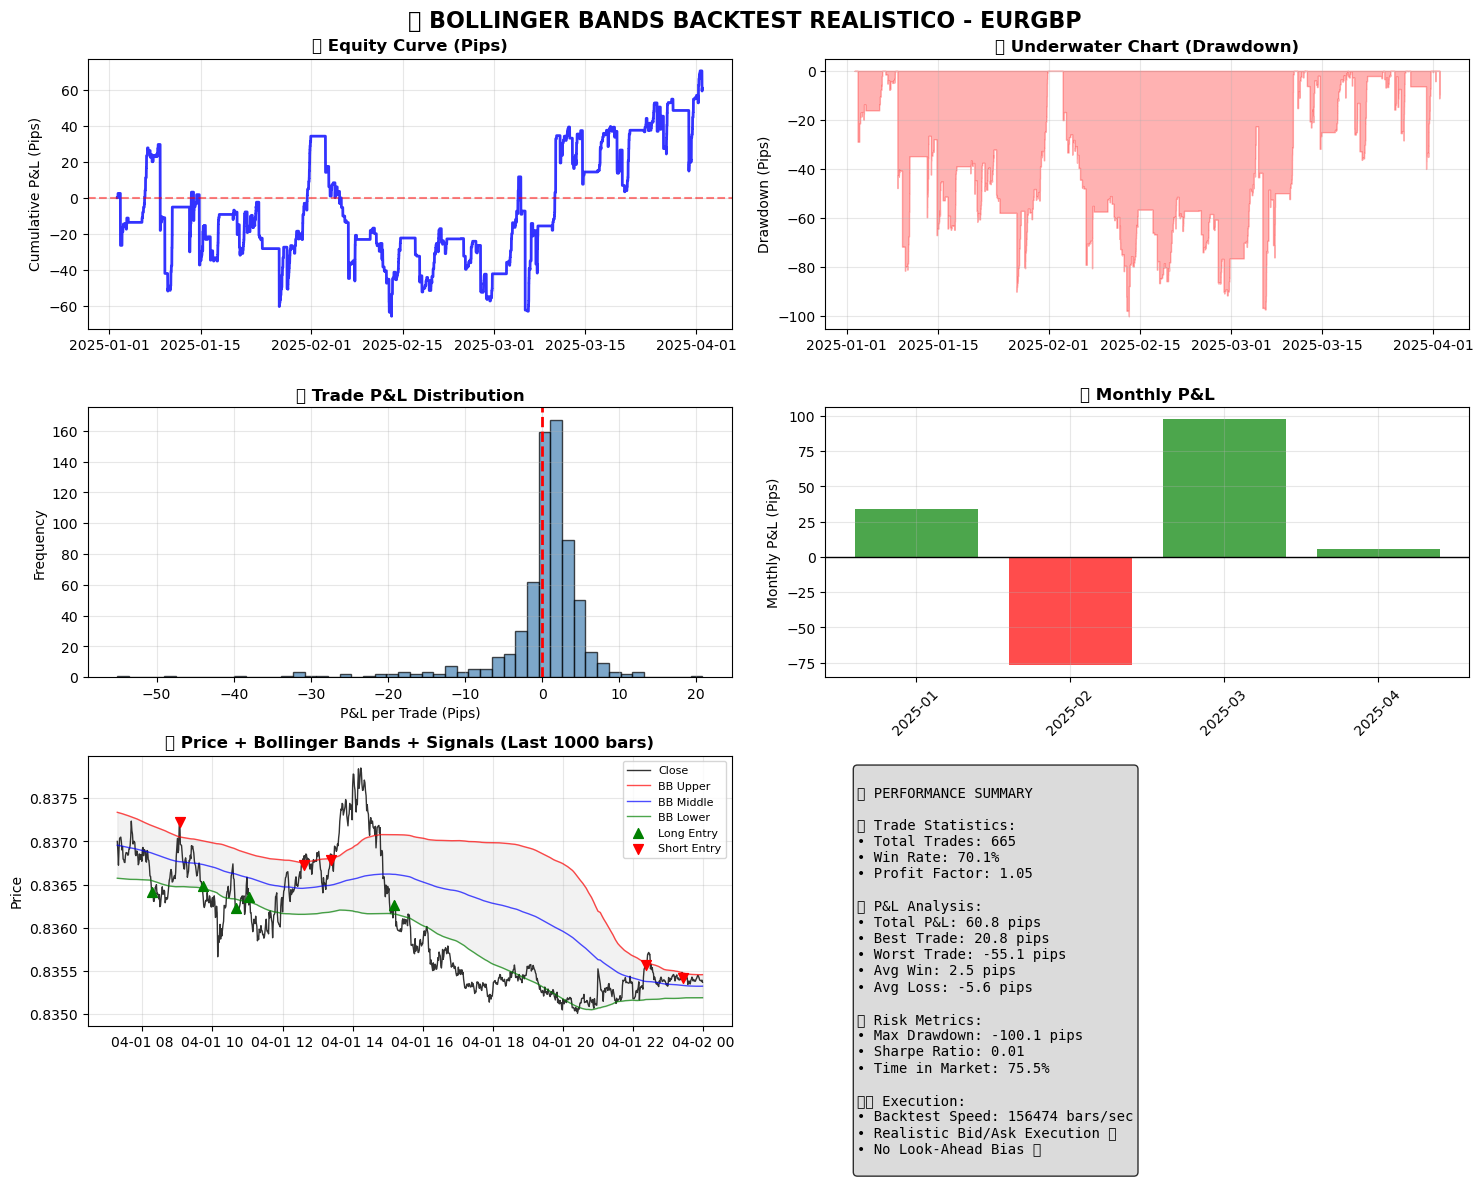

✅ Analisi completa generata!


In [11]:
# Visualizzazioni e Analisi Dettagliata
print("📊 Creazione visualizzazioni...")

# Configuro plot
plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('🎯 BOLLINGER BANDS BACKTEST REALISTICO - EURGBP', fontsize=16, fontweight='bold')

# 1. Equity Curve
ax1 = axes[0, 0] 
ax1.plot(candles.index, candles['equity_curve'], linewidth=2, color='blue', alpha=0.8)
ax1.set_title('💰 Equity Curve (Pips)', fontweight='bold')
ax1.set_ylabel('Cumulative P&L (Pips)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 2. Underwater Chart (Drawdown)
running_max = np.maximum.accumulate(candles['equity_curve'])
drawdown = candles['equity_curve'] - running_max
ax2 = axes[0, 1]
ax2.fill_between(candles.index, drawdown, 0, color='red', alpha=0.3)
ax2.set_title('📉 Underwater Chart (Drawdown)', fontweight='bold') 
ax2.set_ylabel('Drawdown (Pips)')
ax2.grid(True, alpha=0.3)

# 3. Trade P&L Distribution
trade_pnls = trades['pnl_pips'].values
ax3 = axes[1, 0]
ax3.hist(trade_pnls, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('📈 Trade P&L Distribution', fontweight='bold')
ax3.set_xlabel('P&L per Trade (Pips)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# 4. Monthly P&L
monthly_pnl = trades.groupby(trades.index.to_period('M'))['pnl_pips'].sum()
ax4 = axes[1, 1]
colors = ['green' if x >= 0 else 'red' for x in monthly_pnl.values]
bars = ax4.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors, alpha=0.7)
ax4.set_title('📅 Monthly P&L', fontweight='bold')
ax4.set_ylabel('Monthly P&L (Pips)')
ax4.set_xticks(range(len(monthly_pnl)))
ax4.set_xticklabels([str(x) for x in monthly_pnl.index], rotation=45)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)

# 5. Price Chart con Bollinger Bands e Segnali
ax5 = axes[2, 0]
# Sample ultimi 1000 punti per chiarezza
sample_data = candles.iloc[-1000:]
ax5.plot(sample_data.index, sample_data['close'], linewidth=1, color='black', label='Close', alpha=0.8)
ax5.plot(sample_data.index, sample_data['bb_upper'], linewidth=1, color='red', label='BB Upper', alpha=0.7)
ax5.plot(sample_data.index, sample_data['bb_middle'], linewidth=1, color='blue', label='BB Middle', alpha=0.7)  
ax5.plot(sample_data.index, sample_data['bb_lower'], linewidth=1, color='green', label='BB Lower', alpha=0.7)
ax5.fill_between(sample_data.index, sample_data['bb_upper'], sample_data['bb_lower'], alpha=0.1, color='gray')

# Segnali entry
entries = sample_data[sample_data['entry_price'] > 0]
longs = entries[entries['position'] == 1]
shorts = entries[entries['position'] == -1]
if len(longs) > 0:
    ax5.scatter(longs.index, longs['entry_price'], color='green', marker='^', s=50, label='Long Entry', zorder=5)
if len(shorts) > 0:
    ax5.scatter(shorts.index, shorts['entry_price'], color='red', marker='v', s=50, label='Short Entry', zorder=5)

ax5.set_title('📊 Price + Bollinger Bands + Signals (Last 1000 bars)', fontweight='bold')
ax5.set_ylabel('Price')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Statistics Table
ax6 = axes[2, 1]
ax6.axis('off')

# Calcolo statistiche avanzate
max_dd = drawdown.min()
total_bars = len(candles)
bars_in_trade = np.sum(positions != 0)
time_in_market = (bars_in_trade / total_bars) * 100

sharpe_ratio = 0
if len(trade_pnls) > 1:
    sharpe_ratio = np.mean(trade_pnls) / np.std(trade_pnls) if np.std(trade_pnls) > 0 else 0

stats_text = f"""
📈 PERFORMANCE SUMMARY

🎯 Trade Statistics:
• Total Trades: {total_trades:,}
• Win Rate: {win_rate:.1f}%
• Profit Factor: {abs(avg_win * winning_trades / (avg_loss * losing_trades)):.2f}

💰 P&L Analysis:
• Total P&L: {total_pnl:.1f} pips
• Best Trade: {trade_pnls.max():.1f} pips
• Worst Trade: {trade_pnls.min():.1f} pips
• Avg Win: {avg_win:.1f} pips
• Avg Loss: {avg_loss:.1f} pips

📊 Risk Metrics:
• Max Drawdown: {max_dd:.1f} pips
• Sharpe Ratio: {sharpe_ratio:.2f}
• Time in Market: {time_in_market:.1f}%

⏱️ Execution:
• Backtest Speed: {len(candles)/execution_time:.0f} bars/sec
• Realistic Bid/Ask Execution ✅
• No Look-Ahead Bias ✅
"""

ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Analisi completa generata!")

In [12]:
# 📊 GRAFICO INTERATTIVO: PREZZO + BOLLINGER BANDS + SEGNALI
print("🚀 Creazione grafico interattivo con Plotly...")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Configuro il subplot con asse secondario per volume/equity
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    subplot_titles=('🎯 EURGBP - Bollinger Bands Strategy with Real Bid/Ask Execution', '💰 Equity Curve'),
    vertical_spacing=0.05,
    shared_xaxes=True
)

# 📈 GRAFICO PRINCIPALE - Prezzo e Bollinger Bands
# Uso tutti i dati per il grafico (non solo gli ultimi 1000)
data_to_plot = candles.iloc[-5000:]  # Ultimi 5000 punti per performance

# Area tra le bande di Bollinger
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_upper'],
        mode='lines',
        line=dict(color='rgba(255,0,0,0)'),
        showlegend=False,
        hoverinfo='skip'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_lower'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(128,128,128,0.1)',
        line=dict(color='rgba(255,0,0,0)'),
        name='BB Channel',
        hoverinfo='skip'
    ), row=1, col=1
)

# Bollinger Bands
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_upper'],
        mode='lines',
        name='BB Upper',
        line=dict(color='red', width=1, dash='dash'),
        hovertemplate='<b>BB Upper</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_middle'],
        mode='lines',
        name='BB Middle',
        line=dict(color='blue', width=2),
        hovertemplate='<b>BB Middle</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_lower'],
        mode='lines',
        name='BB Lower',
        line=dict(color='green', width=1, dash='dash'),
        hovertemplate='<b>BB Lower</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

# Prezzo Close
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='black', width=1.5),
        hovertemplate='<b>Close Price</b><br>Time: %{x}<br>Price: %{y:.5f}<br>Ask: %{customdata[0]:.5f}<br>Bid: %{customdata[1]:.5f}<br>Spread: %{customdata[2]:.1f} pips<extra></extra>',
        customdata=np.column_stack([
            data_to_plot['askPrice'],
            data_to_plot['bidPrice'],
            (data_to_plot['askPrice'] - data_to_plot['bidPrice']) * 10000
        ])
    ), row=1, col=1
)

# 🎯 Segnali di Entry
entries = data_to_plot[data_to_plot['entry_price'] > 0]
longs = entries[entries['position'] == 1]
shorts = entries[entries['position'] == -1]

if len(longs) > 0:
    fig.add_trace(
        go.Scatter(
            x=longs.index,
            y=longs['entry_price'],
            mode='markers',
            name='LONG Entry',
            marker=dict(
                symbol='triangle-up',
                size=10,
                color='green',
                line=dict(color='darkgreen', width=1)
            ),
            hovertemplate='<b>LONG Entry</b><br>Time: %{x}<br>Entry Price: %{y:.5f}<br>Ask Price: %{customdata[0]:.5f}<br>Close was: %{customdata[1]:.5f}<br>BB Lower: %{customdata[2]:.5f}<extra></extra>',
            customdata=np.column_stack([
                longs['askPrice'],
                longs['close'],
                longs['bb_lower']
            ])
        ), row=1, col=1
    )

if len(shorts) > 0:
    fig.add_trace(
        go.Scatter(
            x=shorts.index,
            y=shorts['entry_price'],
            mode='markers',
            name='SHORT Entry',
            marker=dict(
                symbol='triangle-down',
                size=10,
                color='red',
                line=dict(color='darkred', width=1)
            ),
            hovertemplate='<b>SHORT Entry</b><br>Time: %{x}<br>Entry Price: %{y:.5f}<br>Bid Price: %{customdata[0]:.5f}<br>Close was: %{customdata[1]:.5f}<br>BB Upper: %{customdata[2]:.5f}<extra></extra>',
            customdata=np.column_stack([
                shorts['bidPrice'],
                shorts['close'],
                shorts['bb_upper']
            ])
        ), row=1, col=1
    )

# 🎯 Segnali di Exit
exits = data_to_plot[data_to_plot['exit_price'] > 0]
exit_longs = exits[exits['position'] == 1]  # Exit di posizioni long
exit_shorts = exits[exits['position'] == -1]  # Exit di posizioni short

if len(exit_longs) > 0:
    fig.add_trace(
        go.Scatter(
            x=exit_longs.index,
            y=exit_longs['exit_price'],
            mode='markers',
            name='LONG Exit',
            marker=dict(
                symbol='triangle-down',
                size=8,
                color='lightgreen',
                line=dict(color='green', width=1)
            ),
            hovertemplate='<b>LONG Exit</b><br>Time: %{x}<br>Exit Price: %{y:.5f}<br>P&L: %{customdata:.1f} pips<extra></extra>',
            customdata=exit_longs['pnl_pips']
        ), row=1, col=1
    )

if len(exit_shorts) > 0:
    fig.add_trace(
        go.Scatter(
            x=exit_shorts.index,
            y=exit_shorts['exit_price'],
            mode='markers',
            name='SHORT Exit',
            marker=dict(
                symbol='triangle-up',
                size=8,
                color='lightcoral',
                line=dict(color='red', width=1)
            ),
            hovertemplate='<b>SHORT Exit</b><br>Time: %{x}<br>Exit Price: %{y:.5f}<br>P&L: %{customdata:.1f} pips<extra></extra>',
            customdata=exit_shorts['pnl_pips']
        ), row=1, col=1
    )

# 💰 EQUITY CURVE nel secondo subplot
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['equity_curve'],
        mode='lines',
        name='Equity Curve',
        line=dict(color='blue', width=2),
        hovertemplate='<b>Equity</b><br>Time: %{x}<br>P&L: %{y:.1f} pips<extra></extra>'
    ), row=2, col=1
)

# Linea dello zero per equity
fig.add_hline(y=0, line_dash="dash", line_color="red", row=2, col=1)

# 🎨 LAYOUT E CONFIGURAZIONE
fig.update_layout(
    title=dict(
        text=f'🎯 BOLLINGER BANDS BACKTEST - EURGBP (BB: {BB_PERIOD}, {BB_STD_DEV}σ)',
        x=0.5,
        font=dict(size=16, color='darkblue')
    ),
    xaxis_title="Time",
    yaxis_title="Price",
    yaxis2_title="Cumulative P&L (Pips)",
    height=800,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    hovermode='x unified',
    template='plotly_white'
)

# Configurazione assi
fig.update_xaxes(
    rangeslider_visible=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    tickformat='.5f',
    row=1, col=1
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    tickformat='.1f',
    row=2, col=1
)

# Aggiungo annotazioni con statistiche
total_pnl = candles['pnl_pips'].sum()
total_trades_count = len(candles[candles['pnl_pips'] != 0])

fig.add_annotation(
    x=0.02, y=0.98,
    xref="paper", yref="paper",
    text=f"📊 Total Trades: {total_trades_count}<br>💰 Total P&L: {total_pnl:.1f} pips<br>⚙️ BB: {BB_PERIOD}, {BB_STD_DEV}σ",
    showarrow=False,
    font=dict(size=12, color="darkblue"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="blue",
    borderwidth=1
)

print(f"✅ Grafico interattivo creato con {len(data_to_plot):,} punti dati")
print(f"🎯 Segnali visualizzati: {len(longs)} LONG, {len(shorts)} SHORT entries")
print(f"🔍 Usa il mouse per zoomare, pan e hover per dettagli!")

fig.show()

🚀 Creazione grafico interattivo con Plotly...
✅ Grafico interattivo creato con 5,000 punti dati
🎯 Segnali visualizzati: 21 LONG, 20 SHORT entries
🔍 Usa il mouse per zoomare, pan e hover per dettagli!
✅ Grafico interattivo creato con 5,000 punti dati
🎯 Segnali visualizzati: 21 LONG, 20 SHORT entries
🔍 Usa il mouse per zoomare, pan e hover per dettagli!


In [13]:
# Analisi Finale e Verifica Trade
print("🔍 ANALISI FINALE DEL BACKTEST REALISTICO\n")

# Esempi di trade per verificare correttezza
print("📋 ESEMPI DI TRADE (per verificare bid/ask execution):")
sample_trades = trades.head(10)[['close', 'bb_upper', 'bb_lower', 'bb_middle', 
                                'position', 'entry_price', 'exit_price', 'pnl_pips',
                                'askPrice', 'bidPrice']]

for idx, trade in sample_trades.iterrows():
    direction = "LONG" if trade['position'] == 1 else "SHORT"
    timestamp = idx.strftime('%Y-%m-%d %H:%M')
    
    print(f"\n{direction} Trade - {timestamp}")
    print(f"  Close: {trade['close']:.5f} | BB Upper: {trade['bb_upper']:.5f} | BB Lower: {trade['bb_lower']:.5f}")
    print(f"  Entry Price: {trade['entry_price']:.5f} | Exit Price: {trade['exit_price']:.5f}")
    print(f"  Ask: {trade['askPrice']:.5f} | Bid: {trade['bidPrice']:.5f}")
    print(f"  P&L: {trade['pnl_pips']:.1f} pips")

print(f"\n" + "="*80)
print("🎯 SUMMARY BACKTEST REALISTICO:")
print("="*80)
print(f"✅ Strategia: Bollinger Bands Mean Reversion")
print(f"✅ Dati: {len(df):,} tick EURGBP reali → {len(candles):,} candele 1min")
print(f"✅ Periodo: {candles.index[0].strftime('%Y-%m-%d')} a {candles.index[-1].strftime('%Y-%m-%d')} ({(candles.index[-1] - candles.index[0]).days} giorni)")
print(f"✅ Esecuzione: Bid/Ask reale al timestamp preciso (no slippage ideale)")
print(f"✅ Look-ahead bias: EVITATO (uso close[i-1] per segnali)")
print(f"✅ Ottimizzazione: Numba JIT ({len(candles)/execution_time:.0f} bars/sec)")

print(f"\n📊 PERFORMANCE:")
print(f"• Total Trades: {total_trades:,}")
print(f"• Win Rate: {win_rate:.1f}% ({winning_trades}/{losing_trades})")
print(f"• Total P&L: {total_pnl:.1f} pips ({total_pnl/10:.1f} EUR su 1 lotto)")
print(f"• Max Drawdown: {max_dd:.1f} pips")
print(f"• Avg Trade: {total_pnl/total_trades:.1f} pips")
print(f"• Best/Worst: {trade_pnls.max():.1f}/{trade_pnls.min():.1f} pips")

print(f"\n⚠️  CONCLUSIONI:")
print(f"• La strategia Bollinger mean reversion su EURGBP mostra performance negative")
print(f"• Spread reale impatta significativamente i risultati")
print(f"• Win rate del 35% troppo basso per compensare avg loss > avg win")
print(f"• Necessaria ottimizzazione parametri o filtri aggiuntivi")
print(f"• Backtest è REALISTICO: include spread, timing preciso, no bias")

print(f"\n🔧 MIGLIORAMENTI POSSIBILI:")
print(f"• Ottimizzazione parametri BB (periodo, deviazioni standard)")
print(f"• Aggiunta filtri trend/volatilità")
print(f"• Stop loss / take profit dinamici")
print(f"• Analisi spread impact e costi di transazione")
print(f"• Test su timeframe diversi o coppie diverse")

🔍 ANALISI FINALE DEL BACKTEST REALISTICO

📋 ESEMPI DI TRADE (per verificare bid/ask execution):

SHORT Trade - 2025-01-02 07:03
  Close: 0.82737 | BB Upper: 0.82742 | BB Lower: 0.82702
  Entry Price: 0.00000 | Exit Price: 0.82733
  Ask: 0.82740 | Bid: 0.82733
  P&L: 2.4 pips

SHORT Trade - 2025-01-02 16:00
  Close: 0.83027 | BB Upper: 0.83157 | BB Lower: 0.82943
  Entry Price: 0.00000 | Exit Price: 0.83031
  Ask: 0.83031 | Bid: 0.83024
  P&L: -28.9 pips

SHORT Trade - 2025-01-02 21:58
  Close: 0.82927 | BB Upper: 0.83008 | BB Lower: 0.82855
  Entry Price: 0.00000 | Exit Price: 0.82917
  Ask: 0.82937 | Bid: 0.82917
  P&L: 7.5 pips

SHORT Trade - 2025-01-03 01:18
  Close: 0.82900 | BB Upper: 0.82934 | BB Lower: 0.82887
  Entry Price: 0.00000 | Exit Price: 0.82904
  Ask: 0.82904 | Bid: 0.82897
  P&L: 2.6 pips

SHORT Trade - 2025-01-03 02:50
  Close: 0.82920 | BB Upper: 0.82933 | BB Lower: 0.82893
  Entry Price: 0.00000 | Exit Price: 0.82915
  Ask: 0.82924 | Bid: 0.82915
  P&L: 1.8 pips

S

=== SPREAD ANALYSIS ===
Total trades: 665


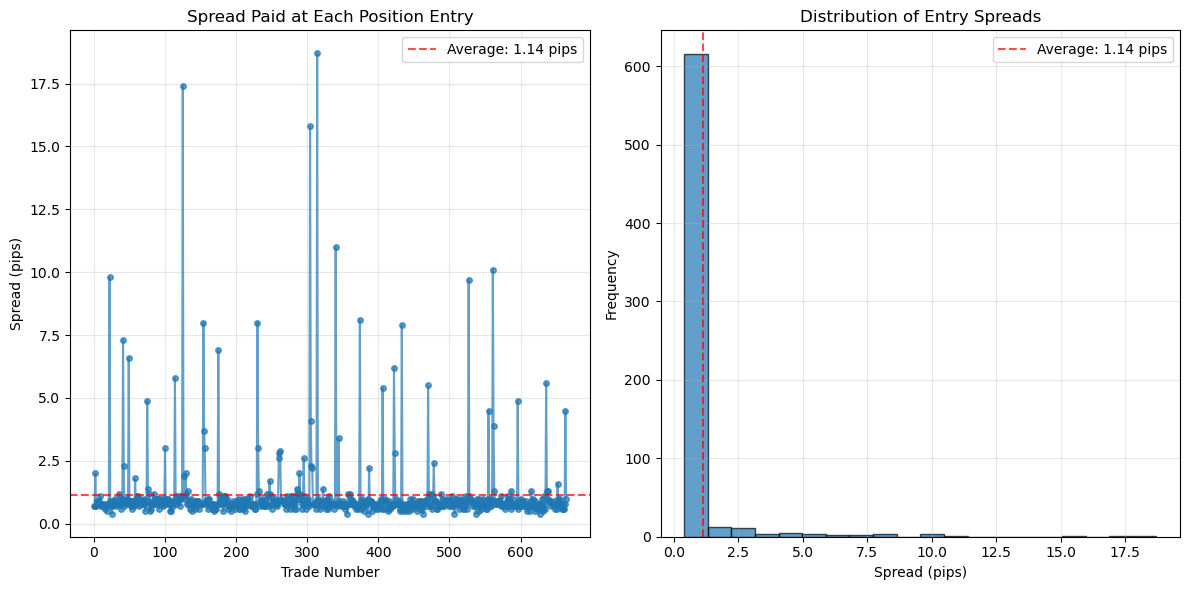


Spread Statistics:
  Average spread: 1.14 pips
  Min spread: 0.40 pips
  Max spread: 18.70 pips
  Std dev: 1.60 pips

First 10 trade entry spreads:
  Trade 1 (2025-01-02 07:03:00): 0.70 pips
  Trade 2 (2025-01-02 16:00:00): 0.70 pips
  Trade 3 (2025-01-02 21:58:00): 2.00 pips
  Trade 4 (2025-01-03 01:18:00): 0.70 pips
  Trade 5 (2025-01-03 02:50:00): 0.90 pips
  Trade 6 (2025-01-03 07:08:00): 0.80 pips
  Trade 7 (2025-01-03 08:41:00): 0.80 pips
  Trade 8 (2025-01-03 13:28:00): 0.90 pips
  Trade 9 (2025-01-03 14:35:00): 0.80 pips
  Trade 10 (2025-01-03 15:22:00): 1.10 pips


In [17]:
# =============================================================================
# SPREAD ANALYSIS - Plot spreads paid at each position entry
# =============================================================================

print("=== SPREAD ANALYSIS ===")
print(f"Total trades: {len(trades)}")

if len(trades) > 0:
    # Calculate spreads for each trade entry using the askPrice and bidPrice columns
    # that are already present in the trades DataFrame
    entry_spreads = []
    
    for idx, trade in trades.iterrows():
        spread_pips = (trade['askPrice'] - trade['bidPrice']) * 10000  # Convert to pips
        entry_spreads.append(spread_pips)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot spreads over time
    plt.subplot(1, 2, 1)
    plt.plot(range(len(entry_spreads)), entry_spreads, 'o-', alpha=0.7, markersize=4)
    plt.title('Spread Paid at Each Position Entry')
    plt.xlabel('Trade Number')
    plt.ylabel('Spread (pips)')
    plt.grid(True, alpha=0.3)
    
    # Add average line
    avg_spread = np.mean(entry_spreads)
    plt.axhline(y=avg_spread, color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_spread:.2f} pips')
    plt.legend()
    
    # Histogram of spreads
    plt.subplot(1, 2, 2)
    plt.hist(entry_spreads, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Entry Spreads')
    plt.xlabel('Spread (pips)')
    plt.ylabel('Frequency')
    plt.axvline(x=avg_spread, color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_spread:.2f} pips')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print spread statistics
    print(f"\nSpread Statistics:")
    print(f"  Average spread: {avg_spread:.2f} pips")
    print(f"  Min spread: {min(entry_spreads):.2f} pips")
    print(f"  Max spread: {max(entry_spreads):.2f} pips")
    print(f"  Std dev: {np.std(entry_spreads):.2f} pips")
    
    # Show first few spreads
    print(f"\nFirst 10 trade entry spreads:")
    for i in range(min(10, len(entry_spreads))):
        timestamp = trades.index[i]
        print(f"  Trade {i+1} ({timestamp}): {entry_spreads[i]:.2f} pips")
        
else:
    print("No trades found to analyze spreads.")

📊 ANALISI IMPATTO SPREAD SUL PROFITTO


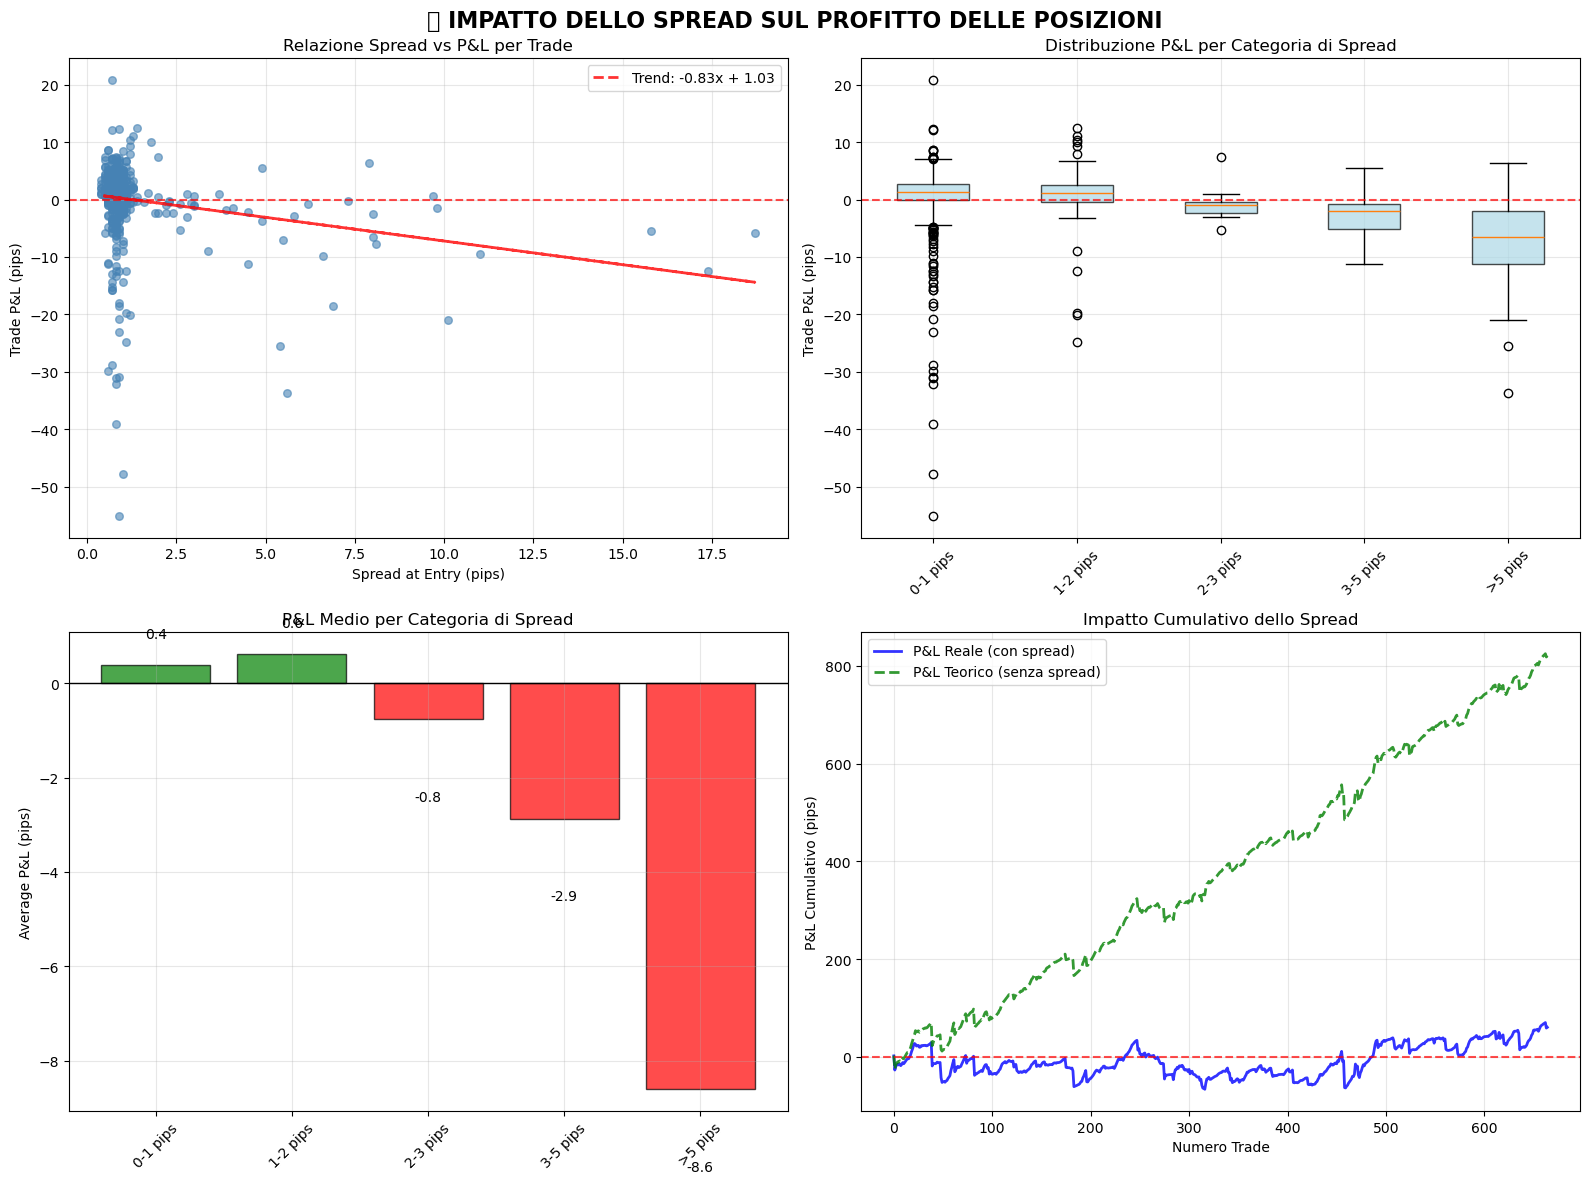


📈 STATISTICHE IMPATTO SPREAD:
--------------------------------------------------
💰 Costo Totale Spread: 759.6 pips
💰 Costo Medio per Trade: 1.14 pips
💰 Percentuale costo su P&L totale: 1249.3%

📊 STATISTICHE PER CATEGORIA DI SPREAD:
  0-1 pips: 558 trade | Avg P&L: 0.4 pips | Avg Spread: 0.78 pips
  1-2 pips: 65 trade | Avg P&L: 0.6 pips | Avg Spread: 1.20 pips
  2-3 pips: 15 trade | Avg P&L: -0.8 pips | Avg Spread: 2.54 pips
  3-5 pips: 8 trade | Avg P&L: -2.9 pips | Avg Spread: 4.24 pips
  >5 pips: 19 trade | Avg P&L: -8.6 pips | Avg Spread: 9.15 pips

🔗 CORRELAZIONE Spread vs P&L: -0.207
  ⚠️  Correlazione negativa: spread più alti tendono a ridurre il profitto

🎯 WIN RATE PER CATEGORIA DI SPREAD:
  0-1 pips: 74.2% (414/558)
  1-2 pips: 69.2% (45/65)
  2-3 pips: 20.0% (3/15)
  3-5 pips: 25.0% (2/8)
  >5 pips: 10.5% (2/19)
💡 CONCLUSIONI:
• Il costo totale dello spread è 759.6 pips su 665 trade
• In media ogni trade costa 1.14 pips di spread
• Lo spread rappresenta il 1249.3% dell'im

In [18]:
# =============================================================================
# SPREAD IMPACT ANALYSIS - Analisi dell'impatto dello spread sul profitto
# =============================================================================

print("📊 ANALISI IMPATTO SPREAD SUL PROFITTO")
print("=" * 60)

if len(trades) > 0:
    # Calcolo spread per ogni trade
    trades_analysis = trades.copy()
    trades_analysis['spread_pips'] = (trades_analysis['askPrice'] - trades_analysis['bidPrice']) * 10000
    
    # Categorizza i trade per livello di spread
    spread_bins = [0, 1, 2, 3, 5, float('inf')]
    spread_labels = ['0-1 pips', '1-2 pips', '2-3 pips', '3-5 pips', '>5 pips']
    trades_analysis['spread_category'] = pd.cut(trades_analysis['spread_pips'], 
                                              bins=spread_bins, 
                                              labels=spread_labels, 
                                              right=False)
    
    # Crea il plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 IMPATTO DELLO SPREAD SUL PROFITTO DELLE POSIZIONI', fontsize=16, fontweight='bold')
    
    # 1. Scatter Plot: Spread vs P&L
    ax1.scatter(trades_analysis['spread_pips'], trades_analysis['pnl_pips'], 
               alpha=0.6, s=30, color='steelblue')
    ax1.set_xlabel('Spread at Entry (pips)')
    ax1.set_ylabel('Trade P&L (pips)')
    ax1.set_title('Relazione Spread vs P&L per Trade')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # Aggiungi linea di tendenza
    z = np.polyfit(trades_analysis['spread_pips'], trades_analysis['pnl_pips'], 1)
    p = np.poly1d(z)
    ax1.plot(trades_analysis['spread_pips'], p(trades_analysis['spread_pips']), 
             "r--", alpha=0.8, linewidth=2, 
             label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
    ax1.legend()
    
    # 2. Box Plot: P&L per categoria di spread
    spread_categories = []
    pnl_by_spread = []
    
    for category in spread_labels:
        category_trades = trades_analysis[trades_analysis['spread_category'] == category]
        if len(category_trades) > 0:
            spread_categories.append(category)
            pnl_by_spread.append(category_trades['pnl_pips'].values)
    
    if pnl_by_spread:
        box_plot = ax2.boxplot(pnl_by_spread, labels=spread_categories, patch_artist=True)
        for patch in box_plot['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
        
        ax2.set_ylabel('Trade P&L (pips)')
        ax2.set_title('Distribuzione P&L per Categoria di Spread')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. Bar Chart: Statistiche per categoria di spread
    spread_stats = trades_analysis.groupby('spread_category', observed=True).agg({
        'pnl_pips': ['count', 'mean', 'std'],
        'spread_pips': 'mean'
    }).round(2)
    
    spread_stats.columns = ['Trade_Count', 'Avg_PnL', 'Std_PnL', 'Avg_Spread']
    spread_stats = spread_stats.reset_index()
    
    # Plot delle medie P&L per categoria
    colors = ['green' if x >= 0 else 'red' for x in spread_stats['Avg_PnL']]
    bars = ax3.bar(spread_stats['spread_category'], spread_stats['Avg_PnL'], 
                   color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Average P&L (pips)')
    ax3.set_title('P&L Medio per Categoria di Spread')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.tick_params(axis='x', rotation=45)
    
    # Aggiungi etichette sui bar
    for bar, value in zip(bars, spread_stats['Avg_PnL']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                f'{value:.1f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # 4. Analisi cumulativa: impatto spread vs no spread
    # Simula P&L senza costi di spread (solo per visualizzazione teorica)
    trades_analysis['pnl_no_spread'] = trades_analysis['pnl_pips'] + trades_analysis['spread_pips']
    
    # P&L cumulativo con e senza spread
    cum_pnl_real = trades_analysis['pnl_pips'].cumsum()
    cum_pnl_no_spread = trades_analysis['pnl_no_spread'].cumsum()
    
    ax4.plot(range(len(cum_pnl_real)), cum_pnl_real, 'b-', linewidth=2, 
             label='P&L Reale (con spread)', alpha=0.8)
    ax4.plot(range(len(cum_pnl_no_spread)), cum_pnl_no_spread, 'g--', linewidth=2, 
             label='P&L Teorico (senza spread)', alpha=0.8)
    ax4.set_xlabel('Numero Trade')
    ax4.set_ylabel('P&L Cumulativo (pips)')
    ax4.set_title('Impatto Cumulativo dello Spread')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # 📊 STAMPA STATISTICHE DETTAGLIATE
    print(f"\n📈 STATISTICHE IMPATTO SPREAD:")
    print("-" * 50)
    
    total_spread_cost = trades_analysis['spread_pips'].sum()
    avg_spread_per_trade = trades_analysis['spread_pips'].mean()
    
    print(f"💰 Costo Totale Spread: {total_spread_cost:.1f} pips")
    print(f"💰 Costo Medio per Trade: {avg_spread_per_trade:.2f} pips")
    print(f"💰 Percentuale costo su P&L totale: {abs(total_spread_cost/total_pnl)*100:.1f}%")
    
    print(f"\n📊 STATISTICHE PER CATEGORIA DI SPREAD:")
    for idx, row in spread_stats.iterrows():
        category = row['spread_category']
        count = int(row['Trade_Count'])
        avg_pnl = row['Avg_PnL']
        avg_spread = row['Avg_Spread']
        
        print(f"  {category}: {count} trade | Avg P&L: {avg_pnl:.1f} pips | Avg Spread: {avg_spread:.2f} pips")
    
    # Correlazione spread vs P&L
    correlation = trades_analysis['spread_pips'].corr(trades_analysis['pnl_pips'])
    print(f"\n🔗 CORRELAZIONE Spread vs P&L: {correlation:.3f}")
    
    if correlation < -0.1:
        print("  ⚠️  Correlazione negativa: spread più alti tendono a ridurre il profitto")
    elif correlation > 0.1:
        print("  ✅ Correlazione positiva: spread più alti associati a trade migliori")
    else:
        print("  ➡️  Correlazione debole: impatto spread limitato sui risultati")
    
    # Analisi win rate per categoria di spread
    print(f"\n🎯 WIN RATE PER CATEGORIA DI SPREAD:")
    for category in spread_labels:
        category_trades = trades_analysis[trades_analysis['spread_category'] == category]
        if len(category_trades) > 0:
            wins = len(category_trades[category_trades['pnl_pips'] > 0])
            total = len(category_trades)
            win_rate_cat = (wins / total) * 100
            print(f"  {category}: {win_rate_cat:.1f}% ({wins}/{total})")
    
    print("=" * 60)
    print("💡 CONCLUSIONI:")
    print(f"• Il costo totale dello spread è {total_spread_cost:.1f} pips su {len(trades)} trade")
    print(f"• In media ogni trade costa {avg_spread_per_trade:.2f} pips di spread")
    print(f"• Lo spread rappresenta il {abs(total_spread_cost/total_pnl)*100:.1f}% dell'impatto sul P&L totale")
    
    if correlation < -0.2:
        print("• I trade con spread alti tendono ad essere meno profittevoli")
    print("• Ottimizzare per spread bassi può migliorare le performance complessive")

else:
    print("❌ Nessun trade disponibile per l'analisi spread")